In [2]:
import os
import json
import pickle
from collections import Counter
import re

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors

import tensorflow as tf

import keras.backend as K
from keras.models import Model, load_model
from keras.layers import Input, Embedding, Dense, Lambda, LSTM
from keras.layers.pooling import _GlobalPooling1D, GlobalAveragePooling1D
from keras.preprocessing.text import text_to_word_sequence, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import get_file

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

%matplotlib inline

/home/alex/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/alex/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/alex/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
sns.set(style="whitegrid", font_scale=1.3)

matplotlib.rcParams["legend.framealpha"] = 1
matplotlib.rcParams["legend.frameon"] = True
matplotlib.rcParams["legend.fontsize"] = 14

matplotlib.rcParams["figure.figsize"] = (10, 8)
matplotlib.rcParams["font.size"] = 14

matplotlib.rcParams["xtick.labelsize"] = 14
matplotlib.rcParams["ytick.labelsize"] = 14

matplotlib.rcParams["axes.labelsize"] = 18
matplotlib.rcParams["axes.titlesize"] = 20

In [4]:
np.random.seed(42)

In [5]:
questions = []
answers = []

In [6]:
with open("../data/pstu_qa/questions.txt") as f:
    content = f.readlines()
questions = [x.strip() for x in content] 
with open("../data/pstu_qa/answers.txt") as f:
    content = f.readlines()
answers = [x.strip() for x in content] 

In [4]:
with open("../data/conversations.txt") as f:
    content = f.readlines()
content = [x.strip() for x in content] 

In [7]:
for i in range(len(content)-3):
    if len(json.loads(content[i]))%2 == 0 and len(json.loads(content[i])) > 0:
        for j in range(0,len(json.loads(content[i])),2):
            questions.append(json.loads(content[i])[j]['text'])
            answers.append(json.loads(content[i])[j+1]['text'])

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [8]:
questions[100:105]

['Здравствуйте. У вас на сайте я наткнулась на Аэрокосмический факультет -   Дизайн бакалавр. Скажите пожалуйста, будет идти набор в 2019г. и в каких формах обучения? (01.11.2018)',
 'Здравствуйте. Давно следил за направлением "Программная инженерия" на электротехническом факультете. С этого года вступительный экзамен с физики был изменен на информатику. Если я правильно понимаю, для поступления ЕГЭ по физике больше не требуется? (31.10.2018)',
 'Здравствуйте, скажите пожалуйста, можно ли поступить с дипломом СПО на СФ с заочной ыормой обусения и сколько это будет стоить (28.10.2018)',
 'Добрый день! Подскажите пожалуйста где можно взять медицинскую справку(чтоб сделать копию) сданную при поступлении на ГНФ? (27.10.2018)',
 'Добрый день! Подскажите пожалуйста где можно взять медицинскую справку(чтоб сделать копию) сданную при поступлении на ГНФ? (27.10.2018)']

In [9]:
answers[100:105]

['Обратитесь в деканат. Подробности в положении',
 '1)Можете, подробно о сроках\xa0 2)Предусмотрена, ее предоставляет вуз 3)Подробно',
 'Можно (но часть).Обратитесь в деканат',
 'Обратитесь в архив университета\xa0(archive@pstu.ru)\xa02-198-058',
 'Весной, ориентировочно 31 марта']

In [11]:
questions_processed = []
answers_processed = []
for i in range(len(answers)):
    # text_to_word_sequence deletes all symbols from the '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
    # and then return individual words from sentencs. After that we join them with spaces
    q = " ".join([w if not w.isdigit() and not bool(re.search(r'[a-zA-Z]', w))
                  else "<num>" for w in text_to_word_sequence(questions[i])])
    a = " ".join([w if not w.isdigit() and not bool(re.search(r'[a-zA-Z]', w))
                  else "<num>" for w in text_to_word_sequence(answers[i])])
    # append to the dataset
    questions_processed.append(q)
    answers_processed.append(a)
questions_processed = np.array(questions_processed)
answers_processed = np.array(answers_processed)

In [17]:
idxs_train, idxs_valid = train_test_split(np.arange(len(questions_processed)), 
                                          random_state=21, test_size=0.1)

In [18]:
len(questions_processed)-len(answers_processed)

0

In [13]:
questions_processed[100:105]

array(['здравствуйте у вас на сайте я наткнулась на аэрокосмический факультет дизайн бакалавр скажите пожалуйста будет идти набор в 2019г и в каких формах обучения <num> <num> <num>',
       'здравствуйте давно следил за направлением программная инженерия на электротехническом факультете с этого года вступительный экзамен с физики был изменен на информатику если я правильно понимаю для поступления егэ по физике больше не требуется <num> <num> <num>',
       'здравствуйте скажите пожалуйста можно ли поступить с дипломом спо на сф с заочной ыормой обусения и сколько это будет стоить <num> <num> <num>',
       'добрый день подскажите пожалуйста где можно взять медицинскую справку чтоб сделать копию сданную при поступлении на гнф <num> <num> <num>',
       'добрый день подскажите пожалуйста где можно взять медицинскую справку чтоб сделать копию сданную при поступлении на гнф <num> <num> <num>'],
      dtype='<U1164')

In [14]:
answers_processed[100:105]

array(['обратитесь в деканат подробности в положении',
       '<num> можете подробно о сроках\xa0 <num> предусмотрена ее предоставляет вуз <num> подробно',
       'можно но часть обратитесь в деканат',
       'обратитесь в архив университета\xa0 <num> <num> <num> \xa02 <num> <num>',
       'весной ориентировочно <num> марта'], dtype='<U1511')

In [19]:
tk = Tokenizer(filters="")

In [20]:
tk.fit_on_texts(np.append(questions_processed[idxs_train], answers_processed[idxs_train]))

In [21]:
number_of_words = len(tk.word_counts)
print("Number of words in the vocabulary = {:d}".format(number_of_words))

Number of words in the vocabulary = 7982


In [22]:
Counter(tk.word_counts).most_common(10)

[('<num>', 16318),
 ('на', 3420),
 ('в', 3372),
 ('и', 1860),
 ('по', 1342),
 ('ли', 1049),
 ('не', 857),
 ('я', 804),
 ('здравствуйте', 772),
 ('можно', 762)]

In [23]:
questions_tokenized = tk.texts_to_sequences(questions_processed)
answers_tokenized = tk.texts_to_sequences(answers_processed)

In [24]:
questions_tokenized[100:105]

[[9,
  29,
  89,
  2,
  64,
  8,
  5890,
  2,
  592,
  36,
  583,
  654,
  76,
  45,
  21,
  824,
  544,
  3,
  2453,
  4,
  3,
  445,
  1607,
  20,
  1,
  1,
  1],
 [9,
  3535,
  5894,
  40,
  1445,
  1687,
  1212,
  2,
  1337,
  157,
  11,
  160,
  148,
  833,
  146,
  11,
  1775,
  401,
  5895,
  2,
  2259,
  12,
  8,
  574,
  878,
  13,
  67,
  42,
  5,
  293,
  747,
  7,
  516,
  1,
  1,
  1],
 [9,
  76,
  45,
  10,
  6,
  44,
  11,
  1016,
  227,
  2,
  449,
  11,
  189,
  5638,
  5639,
  4,
  69,
  61,
  21,
  1180,
  1,
  1,
  1],
 [35,
  19,
  59,
  45,
  46,
  10,
  439,
  585,
  225,
  1157,
  221,
  353,
  3170,
  31,
  127,
  2,
  168,
  1,
  1,
  1],
 [35,
  19,
  59,
  45,
  46,
  10,
  439,
  585,
  225,
  1157,
  221,
  353,
  3170,
  31,
  127,
  2,
  168,
  1,
  1,
  1]]

In [25]:
question_lenghts = np.array(list(map(lambda x: len(x), questions_tokenized)))
answer_lenghts = np.array(list(map(lambda x: len(x), answers_tokenized)))

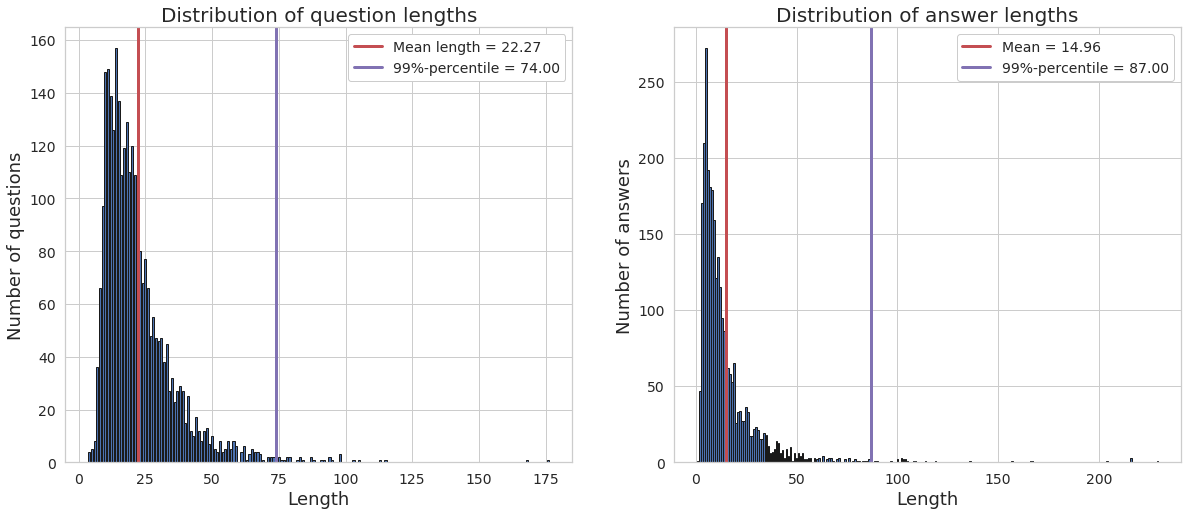

In [26]:
plt.figure(figsize=(20, 8))

plt.subplot(121)
plt.bar(*np.unique(question_lenghts, return_counts=True), edgecolor="k")
plt.axvline(np.mean(question_lenghts), 
            c="r", lw=3, 
            label="Mean length = {:.2f}".format(np.mean(question_lenghts)))
plt.axvline(np.percentile(question_lenghts, 99), 
            c="m", lw=3, 
            label="99%-percentile = {:.2f}".format(np.percentile(question_lenghts, 99)))
plt.xlabel("Length")
plt.ylabel("Number of questions")
plt.title("Distribution of question lengths")
plt.legend()

plt.subplot(122)
plt.bar(*np.unique(answer_lenghts, return_counts=True), edgecolor="k")
plt.axvline(np.mean(answer_lenghts), 
            c="r", lw=3, 
            label="Mean = {:.2f}".format(np.mean(answer_lenghts)))
plt.axvline(np.percentile(answer_lenghts, 99), 
            c="m", lw=3, 
            label="99%-percentile = {:.2f}".format(np.percentile(answer_lenghts, 99)))
plt.xlabel("Length")
plt.ylabel("Number of answers")
plt.title("Distribution of answer lengths")
plt.legend();

In [27]:
cut_length = 30

In [28]:
questions_padded = pad_sequences(questions_tokenized, maxlen=cut_length)
answers_padded = pad_sequences(answers_tokenized, maxlen=cut_length)

In [29]:
q_train, q_valid = questions_padded[idxs_train], questions_padded[idxs_valid]
a_train, a_valid = answers_padded[idxs_train], answers_padded[idxs_valid]

In [30]:
print("Number of train pairs = {:d}".format(len(q_train)))
print("Number of valid pairs = {:d}".format(len(q_valid)))

Number of train pairs = 2626
Number of valid pairs = 292


In [31]:
q_input = Input(shape=(cut_length,), 
                dtype="int32", 
                name="QInput")
a_input = Input(shape=(cut_length,), 
                dtype="int32", 
                name="AInput")

In [32]:
_embedding_layer = Embedding(input_dim=number_of_words + 1,
                             output_dim=200,
                             input_length=cut_length,
                             trainable=True,
                             mask_zero=True, 
                             name="Embedding")

In [33]:
q_embeddeding = _embedding_layer(q_input)
a_embeddeding = _embedding_layer(a_input)

In [34]:
q_rnn = LSTM(64, return_sequences=True, name="QLSTM")(q_embeddeding)
a_rnn = LSTM(64, return_sequences=True, name="ALSTM")(a_embeddeding)

In [35]:
class MaskedGlobalAveragePooling1D(_GlobalPooling1D):
    
    def __init__(self, **kwargs):
        self.support_mask = True
        super(MaskedGlobalAveragePooling1D, self).__init__(**kwargs)
        
    def build(self, input_shape):
        super(MaskedGlobalAveragePooling1D, self).build(input_shape)
        self.feat_dim = input_shape[2]

    def call(self, x, mask=None):
        if mask is not None:
            mask = K.cast(mask, 'float32')
            n = K.sum(mask, axis=-1, keepdims=True)
            n += K.ones_like(n) * K.cast(K.equal(n, 0.0), 'float32')
            ans = K.sum(x, axis=1) / n
        else:
            ans = K.mean(x, axis=1)
        
        return ans

    def compute_mask(self, input_shape, input_mask=None):
        return None

In [36]:
class MaskedGlobalMaxPooling1D(_GlobalPooling1D):
    
    def __init__(self, **kwargs):
        self.support_mask = True
        super(MaskedGlobalMaxPooling1D, self).__init__(**kwargs)
        
    def build(self, input_shape):
        super(MaskedGlobalMaxPooling1D, self).build(input_shape)
        self.feat_dim = input_shape[2]

    def call(self, x, mask=None):
        ans = K.max(x, axis=1)
        return ans

    def compute_mask(self, input_shape, input_mask=None):
        return None

In [37]:
q_max = MaskedGlobalMaxPooling1D(name="QGMP")(q_rnn)
a_max = MaskedGlobalMaxPooling1D(name="AGMP")(a_rnn)

In [38]:
def L2_norm(x):
    return K.l2_normalize(x, axis=1)

In [39]:
q_normalized = Lambda(function=L2_norm, name="QL2norm")(q_max)
a_normalized = Lambda(function=L2_norm, name="AL2norm")(a_max)

In [40]:
def triplet_loss(args):
    
    q, a = args
    
    def _get_probs():
        # easy negative sampling, i.e. take random from batch
        batch_size = tf.shape(a)[0]
        probs = tf.ones((batch_size, batch_size)) - tf.eye(batch_size, batch_size)
        return probs
    
    def _get_distance(batch1, batch2):
        return 1 - tf.reduce_sum(tf.multiply(batch1, batch2), axis=1)
    
    # margin
    alpha = 0.2
    
    # negative sampling
    probs = _get_probs()
    probs /= tf.reduce_sum(probs, axis=1)
    
    negative_idxs = tf.multinomial(tf.log(probs), 1)
    negs = tf.gather(a, negative_idxs)[:, 0]
    
    # distance calculation
    Dn = _get_distance(q, negs)
    Dp = _get_distance(q, a)
    
    # loss
    loss = tf.reduce_mean(tf.maximum(0.0, Dp - Dn + alpha))
    
    return loss

In [41]:
loss_layer = Lambda(function=triplet_loss, name="Loss")([q_normalized, a_normalized])

In [42]:
model = Model(inputs=[q_input, a_input], outputs=[loss_layer])

In [43]:
def dummy_loss(y_true, y_pred):
    return y_pred

In [44]:
model.compile(loss=dummy_loss, optimizer="Adam")

In [45]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
QInput (InputLayer)             (None, 30)           0                                            
__________________________________________________________________________________________________
AInput (InputLayer)             (None, 30)           0                                            
__________________________________________________________________________________________________
Embedding (Embedding)           (None, 30, 200)      1596600     QInput[0][0]                     
                                                                 AInput[0][0]                     
__________________________________________________________________________________________________
QLSTM (LSTM)                    (None, 30, 64)       67840       Embedding[0][0]                  
__________

In [46]:
hist = model.fit([q_train, a_train], np.zeros(q_train.shape[0]), 
                 validation_data=([q_valid, a_valid], np.zeros(q_valid.shape[0])), 
                 epochs=10, batch_size=128)


/home/alex/miniconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 2626 samples, validate on 292 samples
Epoch 1/10
2626/2626 [==============================] - 7s 3ms/step - loss: 0.1987 - val_loss: 0.2042
Epoch 2/10
2626/2626 [==============================] - 5s 2ms/step - loss: 0.1610 - val_loss: 0.1993
Epoch 3/10
2626/2626 [==============================] - 5s 2ms/step - loss: 0.0938 - val_loss: 0.2086
Epoch 4/10
2626/2626 [==============================] - 6s 2ms/step - loss: 0.0497 - val_loss: 0.2065
Epoch 5/10
2626/2626 [==============================] - 5s 2ms/step - loss: 0.0318 - val_loss: 0.2098
Epoch 6/10
2626/2626 [==============================] - 5s 2ms/step - loss: 0.0234 - val_loss: 0.2025
Epoch 7/10
2626/2626 [==============================] - 5s 2ms/step - loss: 0.0191 - val_loss: 0.1995
Epoch 8/10
2626/2626 [==============================] - 5s 2ms/step - loss: 0.0165 - val_loss: 0.2124
Epoch 9/10
2626/2626 [==============================] - 5s 2ms/step - loss: 0.0132 - val_loss: 0.2083
Epoch 10/10
2626/2626 [============

In [47]:
model.save("./rnn_pstu.model")
pickle.dump(hist.history, open("./rnn_pstu.hist", "wb"))

In [48]:
model = load_model("./rnn_pstu.model", custom_objects={"MaskedGlobalMaxPooling1D": MaskedGlobalMaxPooling1D, 
                                                  "tf": tf, 
                                                  "dummy_loss": dummy_loss})
hist = pickle.load(open("./rnn_pstu.hist", "rb"))

/home/alex/miniconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [49]:
q_model = Model(inputs=[model.get_layer("QInput").input], 
                outputs=[model.get_layer("QL2norm").output])
a_model = Model(inputs=[model.get_layer("AInput").input], 
                outputs=[model.get_layer("AL2norm").output])

In [50]:
class QAReplier(object):
    
    def __init__(self, tokenizer, q_model, a_model, **kwargs):
        """
        Constructor
        
        Args:
            tokenizer(keras.Tokenizer): fitted instance of Keras tokenizer class
            q_model(keras.Model):       question encoding tower of DSSM in the form of Keras model
            a_model(keras.Model):       answer encoding tower of DSSM in the form of Keras model
        
        Return:
            self
        """
        
        # call the ancestor constructor
        super(QAReplier, self).__init__(**kwargs)
        # assign passed parameters to the class fields
        self._tk = tokenizer
        self._q_model = q_model
        self._a_model = a_model
        
    def _preprocess(self, bank):
        """
        Preprocess the corpus of sentences into the suitable format
        to feed into the tower.
        
        Args:
            bank(np.ndarray): array of sentences to preprocess
            
        Return:
            bank_padded(np.ndarray): preprocessed and tokenized sentences
        """
        
        bank_processed = []
        # iterate over the corpus
        for i in range(len(bank)):
            # filter out specific symbols, punctuations, 
            # transform numbers into special <num> token, put everything to lower case
            q = " ".join([w if not w.isdigit() and not bool(re.search(r'[a-zA-Z]', w))
                          else "<num>" for w in text_to_word_sequence(bank[i])])
            bank_processed.append(q)
        bank_processed = np.array(bank_processed)
        
        # transform filtered sentences into sequences of tokens
        bank_tokenized = self._tk.texts_to_sequences(bank_processed)
        
        # pad sequences to the desired length (taken from the model input dimensions)
        bank_padded = pad_sequences(bank_tokenized, maxlen=self._q_model.layers[0].input_shape[1])
        
        return bank_padded
        
    def fit(self, answers_bank):
        """
        Fit the replier model to the predefined set of answers.
        All other answers will be chosen from the passed array.
        
        Args:
            answers_bank(np.ndarray): array of sentences from which 
                                      the model can answer

        Return:
            self
        """
        
        self._answers_bank = answers_bank
        # preprocess and then encode answers with the answer tower of DSMM
        _answers_bank_encoded = self._a_model.predict(self._preprocess(self._answers_bank))
        
        # nearest neighbors model to find the most suitable answer
        self._replier = NearestNeighbors(n_neighbors=5, 
                                         metric="minkowski", 
                                         p=2, 
                                         n_jobs=-1, 
                                         algorithm="kd_tree")
        # fir nearest neighbors model on the encoded set of answers
        self._replier.fit(_answers_bank_encoded)
        
        return self
    
    def answer(self, questions, n_answers=5):
        """
        Provide an answer to the given questions.
        
        Args:
            questions(str, list, np.ndarray): questions to the model
            n_answers(int):                   number of top answers to return
            
        Return:
            answers(np.ndarray): array of answers to the given questions
        """
        
        if type(questions) == str:
            questions = np.array([questions])
        elif type(questions) == list:
            questions = np.array(questions)
        elif type(questions) == np.ndarray:
            pass
        else:
            raise ValueError("Wrong format of question")
            
        questions = self._preprocess(questions)
            
        questions_encoded = self._q_model.predict(questions)
        
        res = self._replier.kneighbors(questions_encoded, n_neighbors=n_answers)[1]
        
        return self._answers_bank[res[0][0]],self._answers_bank[res[0][1]],self._answers_bank[res[0][2]]

In [51]:
replier = QAReplier(tk, q_model, a_model)

In [52]:
%%time
replier.fit(answers)

CPU times: user 3.43 s, sys: 201 ms, total: 3.63 s
Wall time: 1.69 s


In [114]:
replier.answer("Подскажите пожалуйста, возможно ли перевестись к вам из другого института?")

('😌', '😌', 'Как совсем?')